In [22]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import numpy as np
import itertools
import datetime
import time
import glob
import cv2
import os
from keras import backend as K
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

### Simple NN

##### Load data

In [2]:
dates = ['24032019', '17042019', '01052019']
labels = ['zeev', 'or', 'ron', 'aviya', 'felix']

TRAIN_AND_VALIDATION_TEST_SPLIT = 0.3
VALID_AND_TEST_SPLIT           = 0.5

In [3]:
# stratified data
x_train = [] 
y_train = []

x_valid = []
y_valid = []

x_test  = []
y_test  = []

In [4]:
def prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test):  
    # for i, l in enumerate(labels):
    for d in dates:
        for i, l in enumerate(labels):
            x_data = []
            y_data = []
            for f in tqdm(glob.glob('../data/frames/{0}/{1}/32/*.png'.format(d, l))):
                x_data.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
                y_data.append(i)
            x_train_label, xx_test_label, y_train_label, yy_test_label \
                             = train_test_split(x_data, y_data, test_size=TRAIN_AND_VALIDATION_TEST_SPLIT)
            x_valid_label, x_test_label, y_valid_label, y_test_label \
                         = train_test_split(xx_test_label, yy_test_label, test_size=VALID_AND_TEST_SPLIT)  

            x_train.append(x_train_label)
            y_train.append(y_train_label)
            x_test.append(x_test_label)
            y_test.append(y_test_label)
            x_valid.append(x_valid_label)
            y_valid.append(y_valid_label)

    x_train = list(itertools.chain.from_iterable(x_train))
    y_train = list(itertools.chain.from_iterable(y_train))
    x_test = list(itertools.chain.from_iterable(x_test))
    y_test = list(itertools.chain.from_iterable(y_test))
    x_valid = list(itertools.chain.from_iterable(x_valid))
    y_valid = list(itertools.chain.from_iterable(y_valid))

    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    x_test  = np.asarray(x_test)
    y_test  = np.asarray(y_test)
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    x_train= x_train / 255.0, 
    x_valid  = x_valid / 255.0
    x_test = x_test / 255.0
    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [5]:
x_train, y_train, x_valid, y_valid, x_test, y_test = prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test)

100%|██████████| 3000/3000 [00:03<00:00, 799.89it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 30000/30000 [00:39<00:00, 757.54it/s] 
0it [00:00, ?it/s]
100%|██████████| 22000/22000 [00:28<00:00, 767.30it/s] 
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 21000/21000 [00:29<00:00, 717.40it/s] 


In [6]:
def show_sample(idx):
    plt.imshow(x_data[idx])
    plt.show()

In [7]:
#Check if stratified

# print(len(y_train),len(y_valid),len(y_test))

# unique, counts = np.unique(y_valid, return_counts=True)
# np.asarray((unique, counts)).T

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
])

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 527,365
Trainable params: 527,365
Non-trainable params: 0
_________________________________________________________________


In [8]:
def set_curr_time():
    dt = datetime.datetime.now()
    curr_dt = '{0}{1}{2}_{3}_{4}'.format(datetime.datetime.now().year, datetime.datetime.now().month,
                                       datetime.datetime.now().day, datetime.datetime.now().hour,
                                      datetime.datetime.now().minute)
    return curr_dt

In [19]:
conf_list = [
#     [32, 512, 0.2],
#     [32, 256, 0.2],
    [32, 256, 0.4,128,0.4]
]

In [23]:
def custom_model(config, model_weights=None):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(config[0], config[0])),
        tf.keras.layers.Dense(config[1]),#, kernel_regularizer=keras.regularizers.l2(0.00001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation(activation=tf.nn.relu),
        tf.keras.layers.Dropout(config[2]),
        tf.keras.layers.Dense(config[3]),#,kernel_regularizer=keras.regularizers.l2(0.0001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation(activation=tf.nn.relu),
        tf.keras.layers.Dropout(config[4]),        
        tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
    ])
    if model_weights is not None:
        print('loading pre-trained model')
        model.load_weights(model_weights, by_name=True)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [24]:
def run_custom_training(conf_list, x_train, y_train, x_valid, y_valid, x_test, y_test, model_path_prefix=None, model_weights=None):
    for conf in conf_list:
        curr_dt = set_curr_time()
        tb_callback = tf.keras.callbacks.TensorBoard(log_dir='../logs/{0}'.format(curr_dt), histogram_freq=0, write_graph=True)
        model = custom_model(conf, model_weights)
        tic = time.time()
        model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=256,
                  epochs=50, callbacks=[tb_callback])
        toc = time.time()
        print('---Test loss & accuracy---')
        model.evaluate(x_test, y_test)
        print('Training time:{}'.format(toc-tic))

#         if model_path_prefix is None:
#             model.save('../models/{0}_{1}.h5'.format(conf, curr_dt))
#         else:
#             model.save('../models/{0}_{1}_{2}.h5'.format(model_path_prefix, conf, curr_dt))
            
run_custom_training(conf_list, x_train, y_train, x_valid, y_valid, x_test, y_test, model_path_prefix=None, model_weights=None)            

Train on 99400 samples, validate on 21300 samples
Epoch 1/50
99400/99400 [==============================] - 8s 83us/sample - loss: 1.3570 - acc: 0.4526 - val_loss: 1.1141 - val_acc: 0.5467
Epoch 2/50
99400/99400 [==============================] - 9s 89us/sample - loss: 1.0930 - acc: 0.5440 - val_loss: 1.1250 - val_acc: 0.5143
Epoch 3/50
99400/99400 [==============================] - 7s 71us/sample - loss: 1.0458 - acc: 0.5677 - val_loss: 1.3360 - val_acc: 0.4726
Epoch 4/50
99400/99400 [==============================] - 6s 55us/sample - loss: 1.0196 - acc: 0.5817 - val_loss: 1.0893 - val_acc: 0.5463
Epoch 5/50
99400/99400 [==============================] - 7s 75us/sample - loss: 0.9990 - acc: 0.5917 - val_loss: 1.0771 - val_acc: 0.5569
Epoch 6/50
99400/99400 [==============================] - 6s 61us/sample - loss: 0.9788 - acc: 0.6008 - val_loss: 0.9822 - val_acc: 0.5968
Epoch 7/50
99400/99400 [==============================] - 7s 70us/sample - loss: 0.9639 - acc: 0.6082 - val_loss: 1.

## CNN

In [7]:
dates = ['24032019', '17042019', '01052019']
labels = ['zeev', 'or', 'ron', 'aviya', 'felix']

TRAIN_AND_VALIDATION_TEST_SPLIT = 0.3
VALID_AND_TEST_SPLIT           = 0.5

CLASSES = 5

# stratified data
x_train = [] 
y_train = []

x_valid = []
y_valid = []

x_test  = []
y_test  = []

In [10]:
def prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test):  
    # for i, l in enumerate(labels):
    for d in dates:
        for i, l in enumerate(labels):
            x_data = []
            y_data = []
            for f in tqdm(glob.glob('../data/frames/{0}/{1}/32/*.png'.format(d, l))):
                x_data.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
                y_data.append(i)
            x_train_label, xx_test_label, y_train_label, yy_test_label \
                             = train_test_split(x_data, y_data, test_size=TRAIN_AND_VALIDATION_TEST_SPLIT)
            x_valid_label, x_test_label, y_valid_label, y_test_label \
                         = train_test_split(xx_test_label, yy_test_label, test_size=VALID_AND_TEST_SPLIT)  

            x_train.append(x_train_label)
            y_train.append(y_train_label)
            x_test.append(x_test_label)
            y_test.append(y_test_label)
            x_valid.append(x_valid_label)
            y_valid.append(y_valid_label)

    x_train = list(itertools.chain.from_iterable(x_train))
    y_train = list(itertools.chain.from_iterable(y_train))
    x_test = list(itertools.chain.from_iterable(x_test))
    y_test = list(itertools.chain.from_iterable(y_test))
    x_valid = list(itertools.chain.from_iterable(x_valid))
    y_valid = list(itertools.chain.from_iterable(y_valid))

    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    x_test  = np.asarray(x_test)
    y_test  = np.asarray(y_test)
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    x_train= x_train / 255.0, 
    x_valid  = x_valid / 255.0
    x_test = x_test / 255.0
    return x_train, y_train, x_valid, y_valid, x_test, y_test
x_train, y_train, x_valid, y_valid, x_test, y_test = prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test)

100%|██████████| 3000/3000 [00:00<00:00, 6020.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 30000/30000 [00:03<00:00, 9867.03it/s] 
0it [00:00, ?it/s]
100%|██████████| 22000/22000 [00:02<00:00, 9872.20it/s] 
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 21000/21000 [00:02<00:00, 9505.11it/s] 


In [16]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_valid = np.asarray(x_valid)
y_valid = np.asarray(y_valid)

In [33]:
x_train.shape
x_train2 = x_train.reshape(x_train.shape[1],x_train.shape[2],x_train.shape[3], 1)
print(x_train2.shape)
x_valid2 = x_valid.reshape(x_valid.shape[0],x_valid.shape[1],x_valid.shape[2], 1)
print(x_valid2.shape)
x_test2 = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2], 1)
print(x_test2.shape)

(99400, 32, 32, 1)
(21300, 32, 32, 1)
(21300, 32, 32, 1)


In [45]:
def set_curr_time():
    dt = datetime.datetime.now()
    curr_dt = '{0}{1}{2}_{3}_{4}'.format(datetime.datetime.now().year, datetime.datetime.now().month,
                                       datetime.datetime.now().day, datetime.datetime.now().hour,
                                      datetime.datetime.now().minute)
    return curr_dt

In [46]:
conf_list = [
    #[32,3,2,0.4, 256, 0.4,128,0.4],
    [64,3,2,0.4, 256, 0.4,128,0.4],
    [32,3,2,0.3, 256, 0.3,128,0.3],
    [64,5,2,0.4, 128, 0.4,64,0.4],
    [64,5,2,0.4, 256, 0.4,128,0.4],
    [128,3,2,0.4, 256, 0.4,128,0.4],
    [32,3,2,0.2, 256, 0.2,128,0.2]
]

In [47]:
def custom_model(config, model_weights=None):
    model = tf.keras.models.Sequential([
 #       tf.keras.layers.Flatten(input_shape=(config[0], config[0])),
        tf.keras.layers.Conv2D(config[0],config[1]),
        tf.keras.layers.MaxPooling2D(pool_size=(config[2], config[2])),
        tf.keras.layers.Dropout(config[3]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(config[4]),#, kernel_regularizer=keras.regularizers.l2(0.00001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation(activation=tf.nn.relu),
        tf.keras.layers.Dropout(config[5]),
        tf.keras.layers.Dense(config[6]),#,kernel_regularizer=keras.regularizers.l2(0.0001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation(activation=tf.nn.relu),
        tf.keras.layers.Dropout(config[7]),        
        tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
    ])
    if model_weights is not None:
        print('loading pre-trained model')
        model.load_weights(model_weights, by_name=True)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [48]:
def run_custom_training(conf_list, x_train, y_train, x_valid, y_valid, x_test, y_test, model_path_prefix=None, model_weights=None):
    for conf in conf_list:
        curr_dt = set_curr_time()
        tb_callback = tf.keras.callbacks.TensorBoard(log_dir='../logs/{0}'.format(curr_dt), histogram_freq=0, write_graph=True)
        model = custom_model(conf, model_weights)
        tic = time.time()
        model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=256,
                  epochs=50, callbacks=[tb_callback])
        toc = time.time()
        print('---Test loss & accuracy---')
        model.evaluate(x_test, y_test)
        print('Training time:{}'.format(toc-tic))

#         if model_path_prefix is None:
#             model.save('../models/{0}_{1}.h5'.format(conf, curr_dt))
#         else:
#             model.save('../models/{0}_{1}_{2}.h5'.format(model_path_prefix, conf, curr_dt))
            
run_custom_training(conf_list, x_train2, y_train, x_valid2, y_valid, x_test2, y_test, model_path_prefix=None, model_weights=None)            

Train on 99400 samples, validate on 21300 samples
Epoch 1/50
99400/99400 [==============================] - 141s 1ms/sample - loss: 1.2211 - acc: 0.4882 - val_loss: 1.0139 - val_acc: 0.5929
Epoch 2/50
99400/99400 [==============================] - 160s 2ms/sample - loss: 0.9533 - acc: 0.6179 - val_loss: 0.9261 - val_acc: 0.6197
Epoch 3/50
99400/99400 [==============================] - 165s 2ms/sample - loss: 0.8589 - acc: 0.6605 - val_loss: 0.8916 - val_acc: 0.6393
Epoch 4/50
99400/99400 [==============================] - 146s 1ms/sample - loss: 0.7789 - acc: 0.6982 - val_loss: 0.7192 - val_acc: 0.7215
Epoch 5/50
99400/99400 [==============================] - 158s 2ms/sample - loss: 0.7160 - acc: 0.7242 - val_loss: 1.0614 - val_acc: 0.5702
Epoch 6/50
99400/99400 [==============================] - 149s 2ms/sample - loss: 0.6561 - acc: 0.7507 - val_loss: 0.7843 - val_acc: 0.7045
Epoch 7/50
99400/99400 [==============================] - 155s 2ms/sample - loss: 0.6065 - acc: 0.7699 - val_l

99400/99400 [==============================] - 112s 1ms/sample - loss: 0.5975 - acc: 0.7769 - val_loss: 0.8240 - val_acc: 0.6781
Epoch 14/50
99400/99400 [==============================] - 111s 1ms/sample - loss: 0.5840 - acc: 0.7819 - val_loss: 0.7740 - val_acc: 0.7061
Epoch 15/50
99400/99400 [==============================] - 111s 1ms/sample - loss: 0.5658 - acc: 0.7896 - val_loss: 1.0127 - val_acc: 0.6015
Epoch 16/50
99400/99400 [==============================] - 112s 1ms/sample - loss: 0.5560 - acc: 0.7939 - val_loss: 0.8531 - val_acc: 0.6869
Epoch 17/50
99400/99400 [==============================] - 112s 1ms/sample - loss: 0.5375 - acc: 0.8012 - val_loss: 0.7999 - val_acc: 0.6990
Epoch 18/50
99400/99400 [==============================] - 112s 1ms/sample - loss: 0.5249 - acc: 0.8060 - val_loss: 0.6176 - val_acc: 0.7747
Epoch 19/50
99400/99400 [==============================] - 112s 1ms/sample - loss: 0.5154 - acc: 0.8110 - val_loss: 0.7466 - val_acc: 0.7313
Epoch 20/50
99400/99400 [

Epoch 20/50
99400/99400 [==============================] - 148s 1ms/sample - loss: 0.3235 - acc: 0.8814 - val_loss: 0.5159 - val_acc: 0.8200
Epoch 21/50
99400/99400 [==============================] - 149s 1ms/sample - loss: 0.3157 - acc: 0.8846 - val_loss: 0.5405 - val_acc: 0.8181
Epoch 22/50
99400/99400 [==============================] - 146s 1ms/sample - loss: 0.3046 - acc: 0.8887 - val_loss: 0.5835 - val_acc: 0.8039
Epoch 23/50
99400/99400 [==============================] - 147s 1ms/sample - loss: 0.3004 - acc: 0.8899 - val_loss: 0.5688 - val_acc: 0.8059
Epoch 24/50
99400/99400 [==============================] - 147s 1ms/sample - loss: 0.2947 - acc: 0.8934 - val_loss: 1.0241 - val_acc: 0.6756
Epoch 25/50
99400/99400 [==============================] - 142s 1ms/sample - loss: 0.2859 - acc: 0.8966 - val_loss: 0.5431 - val_acc: 0.8215
Epoch 26/50
99400/99400 [==============================] - 147s 1ms/sample - loss: 0.2791 - acc: 0.8996 - val_loss: 1.0658 - val_acc: 0.6873
Epoch 27/50
9

Epoch 27/50
99400/99400 [==============================] - 234s 2ms/sample - loss: 0.2027 - acc: 0.9279 - val_loss: 0.6340 - val_acc: 0.8116
Epoch 28/50
99400/99400 [==============================] - 232s 2ms/sample - loss: 0.1981 - acc: 0.9292 - val_loss: 0.5303 - val_acc: 0.8338
Epoch 29/50
99400/99400 [==============================] - 232s 2ms/sample - loss: 0.1909 - acc: 0.9320 - val_loss: 0.6139 - val_acc: 0.8118
Epoch 30/50
99400/99400 [==============================] - 233s 2ms/sample - loss: 0.1868 - acc: 0.9339 - val_loss: 0.5978 - val_acc: 0.8248
Epoch 31/50
99400/99400 [==============================] - 231s 2ms/sample - loss: 0.1852 - acc: 0.9338 - val_loss: 1.1453 - val_acc: 0.7102
Epoch 32/50
99400/99400 [==============================] - 233s 2ms/sample - loss: 0.1806 - acc: 0.9358 - val_loss: 0.5884 - val_acc: 0.8281
Epoch 33/50
99400/99400 [==============================] - 230s 2ms/sample - loss: 0.1746 - acc: 0.9394 - val_loss: 0.6143 - val_acc: 0.8193
Epoch 34/50
9

In [49]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

## resnet 50 model

In [3]:
CLASSES = 5

# stratified data
x_train = [] 
y_train = []

x_valid = []
y_valid = []

x_test  = []
y_test  = []

In [29]:
def prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test):  
    # for i, l in enumerate(labels):
    for d in dates:
        for i, l in enumerate(labels):
            x_data = []
            y_data = []
            for f in tqdm(glob.glob('../data/frames/{0}/{1}/32/*.png'.format(d, l))):
                img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
                f = cv2.resize(img, (224,224))
                f = preprocess_input(f)
#                 img = cv2.resize(cv2.imread(f, cv2.IMREAD_GRAYSCALE), (224,224))
#                 x = preprocess_input(cv2.resize(cv2.imread(f, cv2.IMREAD_GRAYSCALE), (224,224)))
#                 print(img)
#                x_data.append(preprocess_input(cv2.resize(cv2.imread(f, cv2.IMREAD_GRAYSCALE), (224,224))))
                x_data.append(f)

                y_data.append(i)
            x_train_label, xx_test_label, y_train_label, yy_test_label \
                             = train_test_split(x_data, y_data, test_size=TRAIN_AND_VALIDATION_TEST_SPLIT)
            x_valid_label, x_test_label, y_valid_label, y_test_label \
                         = train_test_split(xx_test_label, yy_test_label, test_size=VALID_AND_TEST_SPLIT)  

            x_train.append(x_train_label)
            y_train.append(y_train_label)
            x_test.append(x_test_label)
            y_test.append(y_test_label)
            x_valid.append(x_valid_label)
            y_valid.append(y_valid_label)

    x_train = list(itertools.chain.from_iterable(x_train))
    y_train = list(itertools.chain.from_iterable(y_train))
    x_test = list(itertools.chain.from_iterable(x_test))
    y_test = list(itertools.chain.from_iterable(y_test))
    x_valid = list(itertools.chain.from_iterable(x_valid))
    y_valid = list(itertools.chain.from_iterable(y_valid))

    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    x_test  = np.asarray(x_test)
    y_test  = np.asarray(y_test)
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    x_train= x_train / 255.0, 
    x_valid  = x_valid / 255.0
    x_test = x_test / 255.0
    return x_train, y_train, x_valid, y_valipd, x_test, y_test

x_train, y_train, x_valid, y_valid, x_test, y_test = prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test)

100%|██████████| 3000/3000 [00:05<00:00, 589.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 30000/30000 [03:55<00:00, 16.68it/s] 


MemoryError: 

In [ ]:
x_train.shape

In [23]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_train.shape

(1, 99400, 32, 32)

In [24]:
# x_train = preprocess_input(x_train)
# x_train.shape
# x_train_mod = x_train[0][:, :, :, np.newaxis]
# x_train_mod2= np.repeat(x_train_mod, 3, axis=0)
x_train2 = np.stack((x_train[0],x_train[0], x_train[0]), axis=3)
x_train2.shape

In [37]:
%pwd

u'/home/or/dev/speckles-classification/notebooks'

In [11]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('/home/or/dev/speckles-classification/data/frames/24032019/or',
                                                 target_size=(224,224),
                                                 color_mode='grayscale',
                                                 batch_size=10,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 3000 images belonging to 1 classes.


In [12]:
train_generator.n

3000

In [13]:
CLASSES = 5

base_model = ResNet50(weights=None, include_top=False)
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.2)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=10,
                   epochs=10)
# model.fit(x=x_train[0], y=y_train, batch_size=32, epochs=50)

Epoch 1/10


IndexError: index 1 is out of bounds for axis 2 with size 1

In [5]:
def run_custom_training(x_train, y_train, x_valid, y_valid, x_test, y_test, model_path_prefix=None):
        curr_dt = set_curr_time()
        tb_callback = tf.keras.callbacks.TensorBoard(log_dir='../logs/{0}'.format(curr_dt), histogram_freq=0, write_graph=True)
        tic = time.time()
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks=[tb_callback])
        toc = time.time()
        print('---Test loss & accuracy---')
        model.evaluate(x_test, y_test)
        print('Training time:{}'.format(toc-tic))

#         if model_path_prefix is None:
#             model.save('../models/{0}_{1}.h5'.format(conf, curr_dt))
#         else:
#             model.save('../models/{0}_{1}_{2}.h5'.format(model_path_prefix, conf, curr_dt))
            
run_custom_training( x_train, y_train, x_valid, y_valid, x_test, y_test, model_path_prefix=None)            

NameError: global name 'set_curr_time' is not defined

## Create confusion matrix

In [ ]:
# c_model = tf.keras.models.load_model('../models/[32, 512, 0.1]_201953_12_56.h5')

In [ ]:
# c_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256,
#               epochs=50, callbacks=[tb_callback])

In [ ]:
# c_model.evaluate(x_test, y_test)

In [ ]:
# Evaluate all the models
# for model_path in glob.glob('../models/*.h5'):
#     print(model_path)
#     best_loaded = tf.keras.models.load_model(model_path)
#     best_loaded.evaluate(x_test, y_test)

In [85]:
best_loaded = tf.keras.models.load_model('../models/[32, 512, 0.1]_201953_12_56.h5')
test_predictions = best_loaded.predict(x_test)

In [87]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
confusion

array([[1217,    0,    0,    0,    0,    0,    0],
       [   0, 3174,  309,  879,    0,  645,    0],
       [   0,  177, 5386,  443,    0,  630,    0],
       [   0,  569,  666, 4133,    0, 1290,    0],
       [   0,    0,    0,    0, 1153,    0,    0],
       [   0,  289,  546,  924,    0, 4137,    0],
       [   0,    0,    0,    0,    0,    0,  633]])

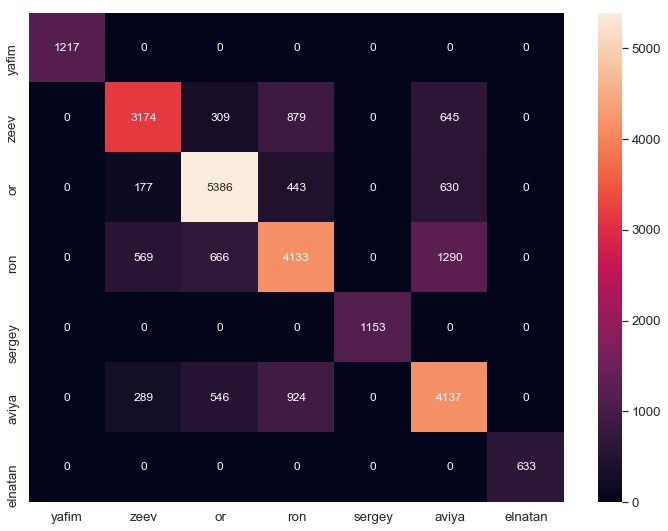

In [104]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion, labels, labels)
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, fmt='.5g', annot_kws={"size": 12})

In [105]:
df_cm

,yafim,zeev,or,ron,sergey,aviya,elnatan
yafim,1217,0,0,0,0,0,0
zeev,0,3174,309,879,0,645,0
or,0,177,5386,443,0,630,0
ron,0,569,666,4133,0,1290,0
sergey,0,0,0,0,1153,0,0
aviya,0,289,546,924,0,4137,0
elnatan,0,0,0,0,0,0,633
